## Set Up

In [1]:
# Importing the libraries

import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.layers import MaxPool2D
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Assing paths to variables

train_path = "../data/train"
test_path = "../data/test"
valid_path = "../data/valid"

In [3]:
# Creating batches

train_batch = ImageDataGenerator().flow_from_directory(train_path, target_size=(224, 224), classes=['dog', 'cat'], batch_size=10)
test_batch = ImageDataGenerator().flow_from_directory(test_path, target_size=(224, 224), classes=['dog', 'cat'], batch_size=10)
valid_batch = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224, 224), classes=['dog', 'cat'], batch_size=4)

Found 40 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [4]:
# Plot images with labels within jupyter notebook

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [5]:
# Grabbing one batch of 10 images each time it is called

imgs, labels = next(train_batch)

/home/themlguy/anaconda3/envs/Tensorflow/lib/python3.6/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


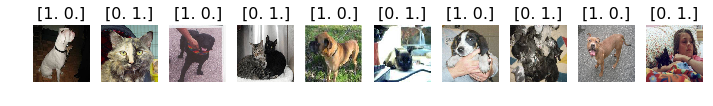

In [6]:
plots(imgs, titles=labels)

# Building and Training a CNN

In [7]:
model = Sequential([
    Conv2D(6, (5, 5), activation='relu', input_shape=(224, 224, 3)),
    Flatten(),
    Dense(2, activation='softmax')
])

In [8]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.fit_generator(train_batch, steps_per_epoch=4, validation_data=valid_batch, validation_steps=4, epochs=5, verbose=2)

Epoch 1/5
 - 2s - loss: 7.6561 - acc: 0.5250 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/5
 - 1s - loss: 8.8650 - acc: 0.4500 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/5
 - 1s - loss: 6.8502 - acc: 0.5750 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/5
 - 1s - loss: 9.2679 - acc: 0.4250 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/5
 - 1s - loss: 7.2531 - acc: 0.5500 - val_loss: 8.0590 - val_acc: 0.5000


# Prediction 

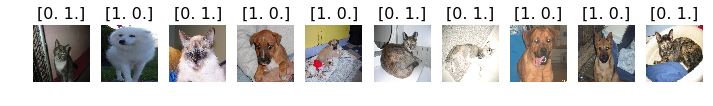

In [10]:
test_imgs, test_labels = next(test_batch)
plots(test_imgs, titles=test_labels)

In [11]:
# To make the labels of [1. 0] to [1.] and [0. 1] to [0.], using only the first index

test_labels = test_labels[:, 0]
test_labels

array([0., 1., 0., 1., 1., 0., 0., 1., 1., 0.], dtype=float32)

In [12]:
predictions = model.predict_generator(test_batch, steps=1, verbose=0)

In [13]:
predictions

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [14]:
cm = confusion_matrix(test_labels, predictions[:, 0])

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Confusion matrix, without normalization
[[0 5]
 [0 5]]


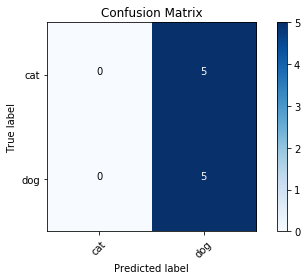

In [16]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### The accuracy of the predictions is pretty blunt

# Fine Tuning the VGG-16 Model

In [39]:
vgg16 = keras.applications.vgg16.VGG16()

In [40]:
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [41]:
type(vgg16)

keras.engine.training.Model

In [42]:
model2 = Sequential()
for layer in vgg16.layers[:-1]:
    model2.add(layer)

In [43]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [44]:
for layer in model2.layers:
    layer.trainable=False

In [45]:
model2.add(Dense(2, activation='softmax'))

In [46]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

# Training the VGG16 clone model

In [47]:
model2.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
model2.fit_generator(train_batch, steps_per_epoch=4, validation_data=valid_batch, validation_steps=4, epochs=10, verbose=2)

Epoch 1/10
 - 12s - loss: 1.0972 - acc: 0.5000 - val_loss: 0.9320 - val_acc: 0.6250
Epoch 2/10
 - 10s - loss: 0.6932 - acc: 0.6000 - val_loss: 0.3911 - val_acc: 0.7500
Epoch 3/10
 - 11s - loss: 0.5097 - acc: 0.7750 - val_loss: 0.7485 - val_acc: 0.6875
Epoch 4/10
 - 12s - loss: 0.4112 - acc: 0.8000 - val_loss: 0.6500 - val_acc: 0.6875
Epoch 5/10
 - 12s - loss: 0.2385 - acc: 0.8750 - val_loss: 0.3325 - val_acc: 0.9375
Epoch 6/10
 - 12s - loss: 0.2234 - acc: 0.8750 - val_loss: 0.5171 - val_acc: 0.8750
Epoch 7/10
 - 12s - loss: 0.2099 - acc: 0.8250 - val_loss: 0.2244 - val_acc: 0.8750
Epoch 8/10
 - 12s - loss: 0.1374 - acc: 0.9250 - val_loss: 0.3540 - val_acc: 0.8125
Epoch 9/10
 - 12s - loss: 0.1178 - acc: 0.9750 - val_loss: 0.4654 - val_acc: 0.8750
Epoch 10/10
 - 12s - loss: 0.0888 - acc: 1.0000 - val_loss: 0.3012 - val_acc: 0.8750


# Predict using fine-tuned VGG16

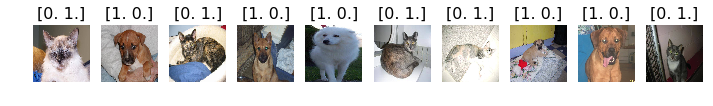

In [57]:
test_imgs, test_labels = next(test_batch)
plots(test_imgs, titles=test_labels)

In [58]:
# To make the labels of [1. 0] to [1.] and [0. 1] to [0.], using only the first index

test_labels = test_labels[:, 0]
test_labels

array([0., 1., 0., 1., 1., 0., 0., 1., 1., 0.], dtype=float32)

In [59]:
predictions = model2.predict_generator(test_batch, steps=1, verbose=0).round()

In [60]:
predictions

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [61]:
cm = confusion_matrix(test_labels, predictions[:, 0])

Confusion matrix, without normalization
[[4 1]
 [2 3]]


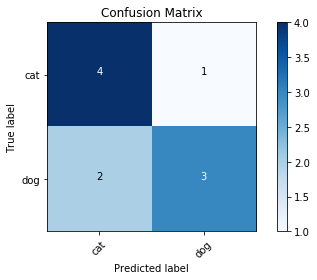

In [62]:
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### We got 70% Accuracy in Prediction

# Saving the model

In [63]:
model2.save('VGG16_CatsNDogs.h5')